# CIRCULAR EVALUATION

In [99]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
from skimage import draw
from scipy import signal
from scipy.stats import multivariate_normal as mn
from sklearn.covariance import EmpiricalCovariance as ecov
from PIL import Image

In [45]:
global_factor = 4

def image_open(name):
    location='from_camera/test06/'+name+'.png'
    image_im = Image.open(location)
    realsize=image_im.size
    newsize=tuple(int(ti/global_factor) for ti in realsize)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

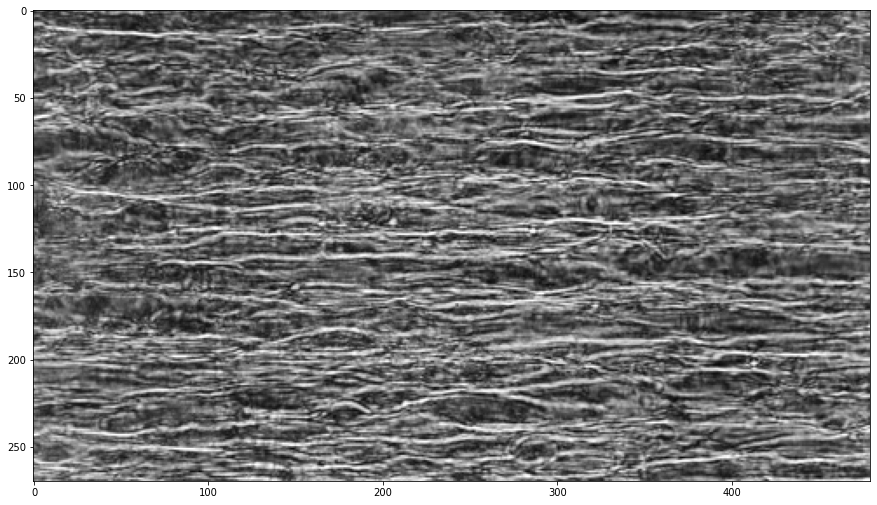

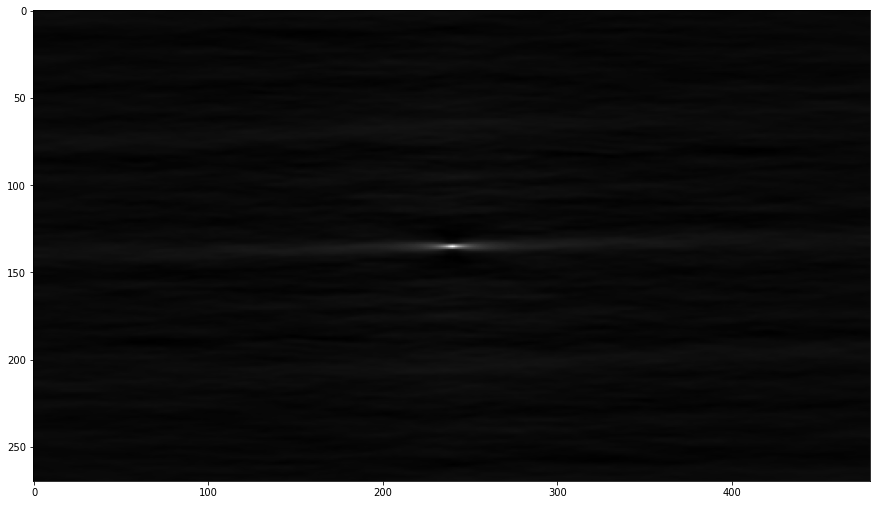

In [46]:
h = image_open('a_psf')
h -= h.mean()
plt.figure(figsize=(15,15))
plt.imshow(h,cmap='gray')
plt.show()

plt.figure(figsize=(15,15))
plt.imshow(signal.fftconvolve(h,np.flip(h),mode='same'),cmap='gray')
plt.show()

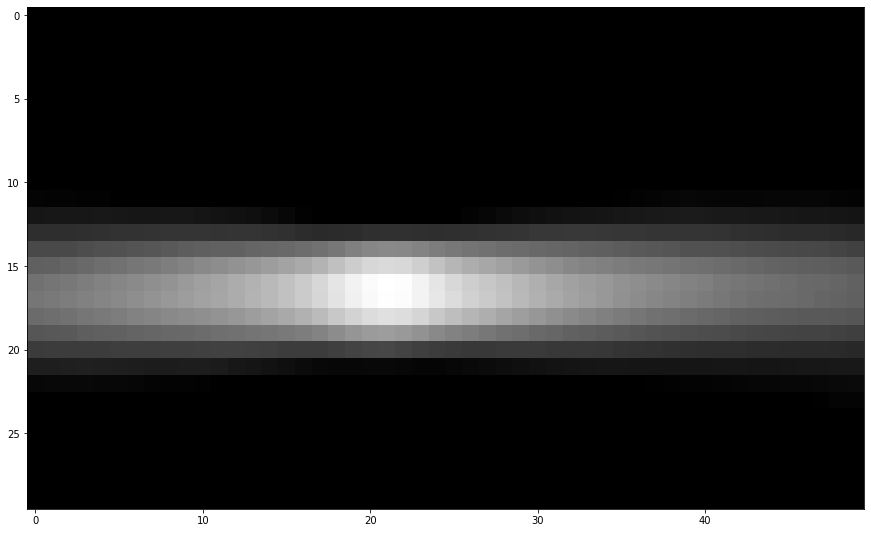

In [47]:
bigdot = image_open('b_bigdotcenter')
black = image_open('b_black1')
bigdot -= black
bigdot -= bigdot.mean()
bigdot_hat = signal.fftconvolve(bigdot,np.flip(h),mode='same')
# plt.figure(figsize=(15,15))
# plt.imshow(bigdot_hat ,cmap='gray')
# plt.show()
(sy,sx)=bigdot_hat.shape
bigdot_hat = bigdot_hat[math.floor(sy/2)+5:math.floor(sy/2)+35,math.floor(sx/2)-25:math.floor(sx/2)+25]
bigdot_hat = np.maximum(bigdot_hat,np.ones(bigdot_hat.shape))
plt.figure(figsize=(15,15))
plt.imshow(bigdot_hat ,cmap='gray')
plt.show()

## Part II _ simulation

In [48]:
def perimeter(image):
    opx=np.array([[1,0],[0,-1]])
    opy=np.array([[0,1],[-1,0]])
    image_x=signal.fftconvolve(image,opx,mode='same')
    image_y=signal.fftconvolve(image,opy,mode='same')
    image_xy=abs(image_x)+abs(image_y)
    image_xy = np.minimum(image_xy,np.ones(image_xy.shape))
    number = sum(sum(image_xy))
    plt.figure(figsize=(20,20))
    plt.imshow(image_xy,cmap='gray')
    plt.show()
    return number

def area(image):
    number = sum(sum(image))
    return number

def ratio_circularity(image):
    im_perim = perimeter(image)
    im_area = area(image)
    ratio = (im_perim**2)/(4*np.pi*im_area)
    return ratio

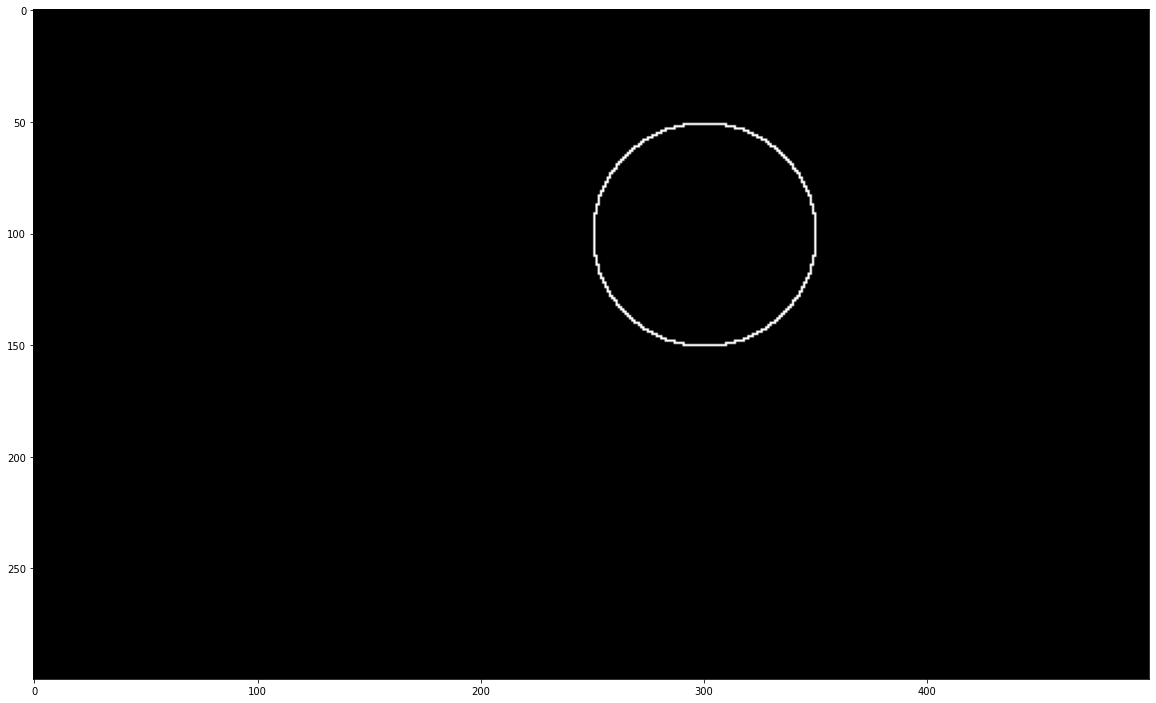

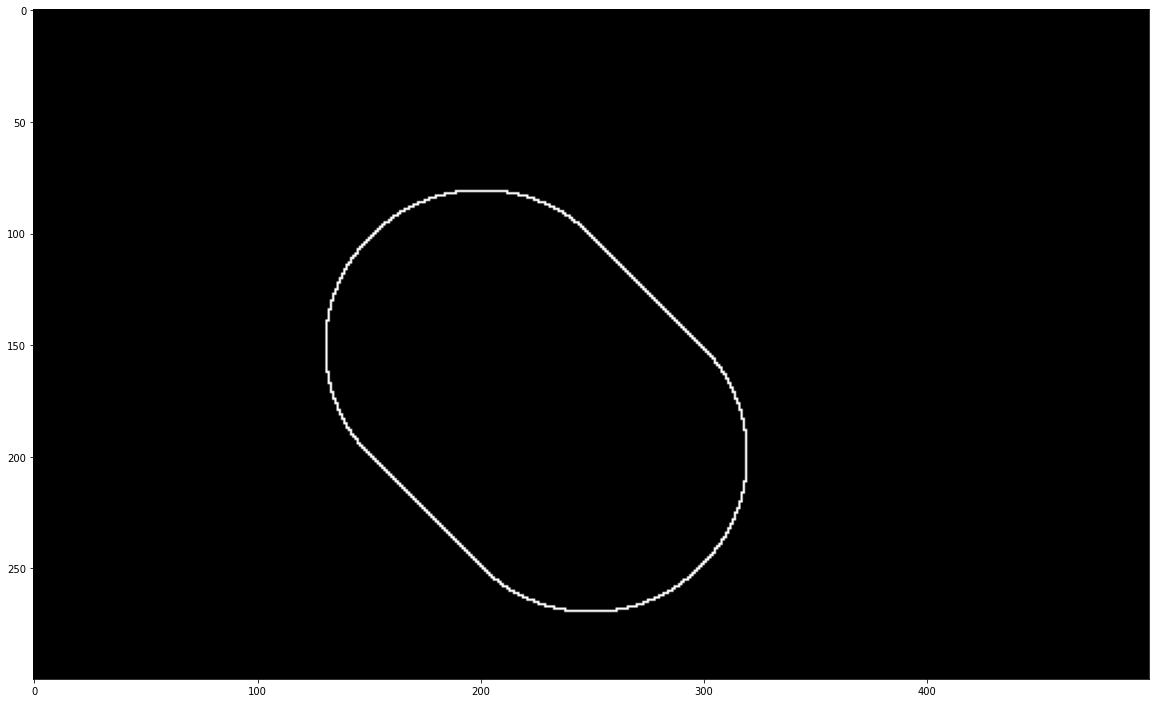

1.5947630387156708 1.7990476720684914


In [49]:
circle1 = np.zeros((300,500),dtype=float)
[rr,cc] = draw.disk((100,300),50)
circle1[rr,cc] = 1


circle2 = np.zeros((300,500),dtype=float)
for i in range(50):
    [rr,cc] = draw.disk((150+i,200+i),70)
    circle2[rr,cc] = 1

print(ratio_circularity(circle1),ratio_circularity(circle2))
# perimeter(circle2)
# plt.imshow(circle1,cmap='gray')
# plt.show()
# plt.imshow(circle2,cmap='gray')
# plt.show()

## Part 3 - PDF

In [50]:
def gauss_pdf(x,u,s):
    out = np.linalg.det(2*np.pi*s)**(-0.5)*np.exp(-0.5*np.transpose(x-u)*np.invert(s)*(x-u))
    return out

(array([2., 2.]), array([[1., 0.],
       [0., 1.]]))


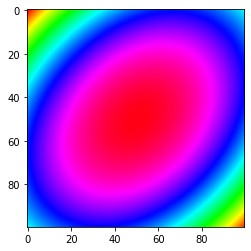

In [51]:
pdf_mm = np.zeros((100,100))
sx,sy = pdf_mm.shape
u = np.array([[50],[50]])
s=np.array([[2,0],[0,2]])
print(np.linalg.eig(s))

for i in range(sx):
    for j in range(sy):
        x = np.array([[i],[j]])
        prod = np.dot(np.dot(np.transpose(x-u),np.invert(s)),(x-u))
        # expo = np.exp(-0.5*prod)
        # out = np.linalg.det(2*np.pi*s)**(-0.5)*np.exp(-0.5*prod)

        pdf_mm[i,j] = prod

plt.imshow(pdf_mm,cmap='hsv')
plt.show()

## Part 4 - PDF using function

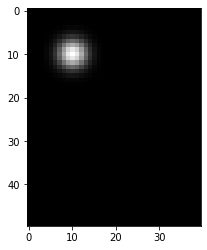

In [72]:
pdf_map = np.zeros((50,40))
sx,sy = pdf_map.shape
u = np.array([10,10])
s=np.array([[5,0],[0,5]])

for i in range(sx):
    for j in range(sy):
        x = np.array([i,j])
        pdf_map[i,j] = mn.pdf(x,u,s)

plt.imshow(pdf_map,cmap='gray')
plt.show()

Now, we will try to recover Σ and μ.

In [127]:
def circ_ratio_from_pdf(pdf):
    sx,sy = pdf.shape

    pdf /= np.sum(pdf) #Normalize

    u_a = np.array([0,0],dtype=float)
    for i in range(sx):
        for j in range(sy):
            u_a += np.array([i,j])*pdf[i,j]

    s_a = np.array([[0,0],[0,0]],dtype=float)
    for i in range(sx):
        for j in range(sy):
            prod = (np.array([i,j])-u_a)
            s_a += prod*prod[None].T*pdf[i,j]
    
    eigen = abs(np.linalg.eigvals(s_a))
    circular_ratio = max(eigen)/min(eigen)
    
    print('matrix sum =',np.sum(pdf))
    print('μ_a =',u_a)
    print('Σ_a =',s_a)
    print('circularity =',circular_ratio)

    # return circular_ratio  

In [93]:
circ_ratio_from_pdf(pdf_map)

matrix sum = 1.0
μ_a = [10.00001222 10.00001222]
Σ_a = [[4.99986967e+00 1.48737112e-17]
 [1.48737112e-17 4.99986967e+00]]
circularity = 1.0000000000000007


# Part 5 - Real image

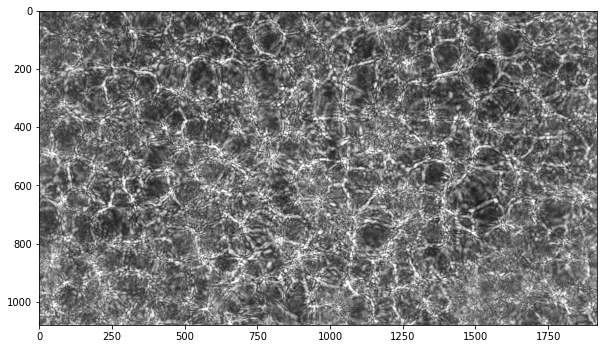

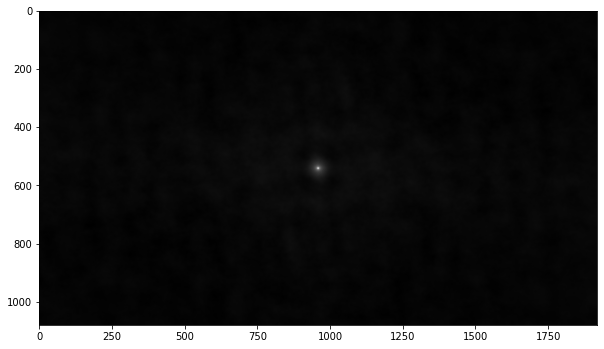

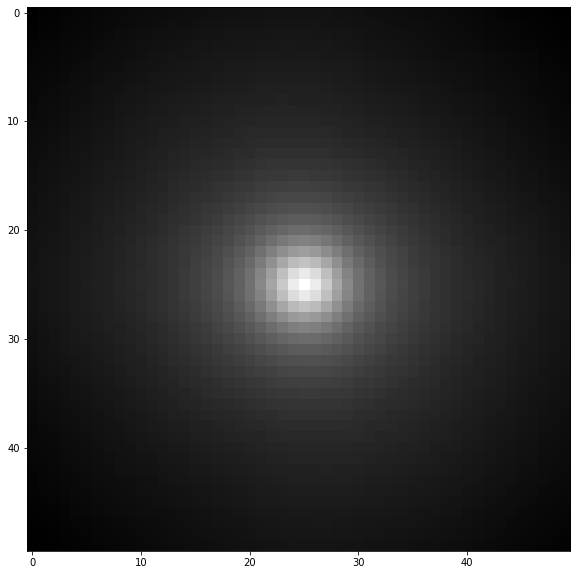

In [117]:
global_factor = 1

def image_open(name):
    location='from_camera/test10/'+name+'.png'
    image_im = Image.open(location)
    realsize=image_im.size
    newsize=tuple(int(ti/global_factor) for ti in realsize)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

h = image_open('h') - image_open('h_black')
h -= h.mean()
plt.figure(figsize=(10,10))
plt.imshow(h,cmap='gray')
# plt.savefig('resultats/circ/h.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,10))
h_auto = signal.fftconvolve(h,np.flip(h),mode='same')
plt.imshow(h_auto,cmap='gray')
# plt.savefig('resultats/circ/h_auto.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,10))
h_s = h_auto.shape
h_s = tuple(int(wdth/2) for wdth in h_s)
zoom = 25
h_auto_zoom = h_auto[h_s[0]-zoom:h_s[0]+zoom,h_s[1]-zoom:h_s[1]+zoom]
plt.imshow(h_auto_zoom,cmap='gray')
plt.show()

In [118]:
print('\nFROM ZOOMED IMAGE')
circ_ratio_from_pdf(h_auto_zoom)


FROM ZOOMED IMAGE
matrix sum = 1.0
μ_a = [24.71942849 24.7219245 ]
Σ_a = [[152.00443998   4.49049268]
 [  4.49049268 153.28871841]]
circularity = 1.0612539432281818


## Part 5B

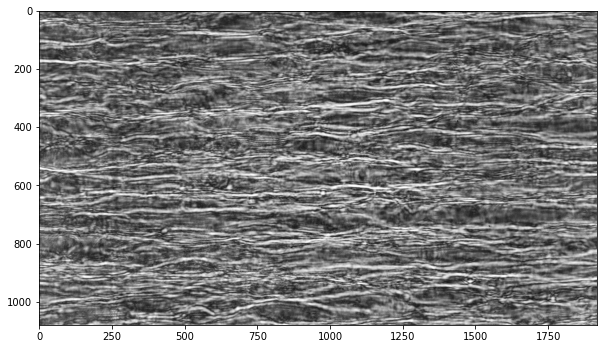

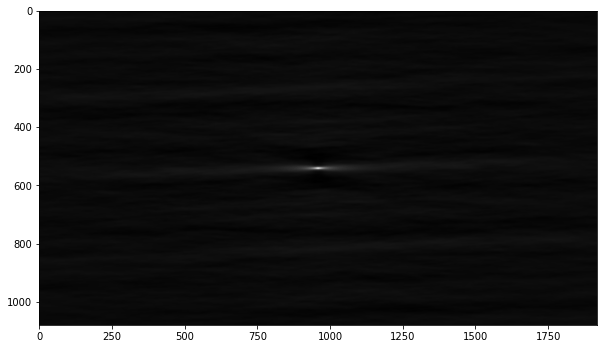

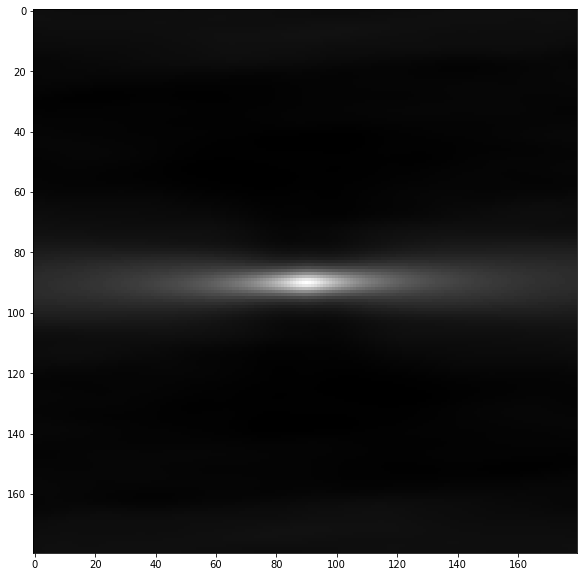

In [132]:
global_factor = 1

def image_open(name):
    location='from_camera/test07/'+name+'.png'
    image_im = Image.open(location)
    realsize=image_im.size
    newsize=tuple(int(ti/global_factor) for ti in realsize)
    image_im=image_im.resize(newsize,Image.ANTIALIAS)
    image_im = np.array(image_im,dtype=float)
    image_im = image_im[:, :, 0]
    return image_im

h = image_open('h')
h -= h.mean()
plt.figure(figsize=(10,10))
plt.imshow(h,cmap='gray')
plt.show()

plt.figure(figsize=(10,10))
h_auto = signal.fftconvolve(h,np.flip(h),mode='same')
plt.imshow(h_auto,cmap='gray')
plt.show()

plt.figure(figsize=(10,10))
h_s = h_auto.shape
h_s = tuple(int(wdth/2) for wdth in h_s)
zoom = 90
h_auto_zoom = h_auto[h_s[0]-zoom:h_s[0]+zoom,h_s[1]-zoom:h_s[1]+zoom]
plt.imshow(h_auto_zoom,cmap='gray')
plt.show()

In [133]:
print('\nFROM ZOOMED IMAGE')
circ_ratio_from_pdf(h_auto_zoom)


FROM ZOOMED IMAGE
matrix sum = 1.0
μ_a = [89.49314716 89.67392335]
Σ_a = [[-1154.16176798  -138.73188634]
 [ -138.73188634  2228.76331391]]
circularity = 1.926507199303438


# Part 6 - Image and Function

In [105]:
zoom_normalized = h_auto_zoom/np.sum(h_auto_zoom) #Normalize
cov = ecov().fit(h_auto_zoom)
cov.covariance_
cov.location_

array([0.0003805 , 0.00039728, 0.00041465, 0.00043269, 0.00045161,
       0.00047166, 0.00049292, 0.00051526, 0.00053842, 0.0005623 ,
       0.0005872 , 0.00061377, 0.00064268, 0.00067487, 0.00071176,
       0.0007549 , 0.00080516, 0.0008619 , 0.00092093, 0.00097091,
       0.00099231, 0.00097078, 0.00092066, 0.0008615 , 0.00080466,
       0.00075429, 0.00071107, 0.00067408, 0.00064181, 0.00061283,
       0.00058621, 0.00056128, 0.00053739, 0.00051424, 0.00049191,
       0.00047068, 0.0004507 , 0.00043186, 0.00041386, 0.00039652])

In [107]:
covcov=np.cov(zoom_normalized)
covcov.shape


(40, 40)